# Testing Deferred Revenue in Python
Will this be easier for everyone to use than Matlab?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Processing Base Billings Data

In [2]:
df = pd.read_excel('../data/old/base_billings.xlsx', sheet_name='bill_DC')

In [3]:
df.sample(10)

,Document Currency,Enterprise Bu,Frequency,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Revenue Recognition Category New,Rule For Bill Date,Sales Type,Subscription Term,Completed Sales Doc Currency
9520,EUR,Document Cloud,NaN,2017-04,MTHLY,A,NaN,DEFERRED,1,-1400.75
12055,EUR,Experience Cloud,CERT,2018-12,1Y,D,YA,DEFERRED,12,516160.88
4612,CAD,LiveCycle,NaN,2017-05,NaN,NaN,NaN,RECOGNIZED,0,1281.80
22,AUD,Creative,NaN,2015-06,2V,NaN,NaN,RECOGNIZED,0,1974.00
4678,CAD,Print & Publishing,NaN,2016-11,1Y,A,NaN,DEFERRED,12,-2391.95
6445,CHF,Print & Publishing,NaN,2018-07,1Y,A,NaN,DEFERRED,1,16.50
14871,GBP,Document Cloud,NaN,2019-01,MTHLY,D,Y3,DEFERRED,1,25203.96
27802,USD,Experience Cloud,NaN,2016-07,1Y,A,NaN,DEFERRED,0,1074848.01
5206,CHF,Creative,NaN,2018-11,1Y,NaN,NaN,RECOGNIZED,0,0.00
8487,EUR,Creative,NaN,2017-03,1Y,NaN,NaN,DEFERRED,0,0.00


## Filter that removes any currency that has  < 10 transactions. 


In [4]:
# creates a list of the currencies and the number of transactions for each currency
vc = df['Document Currency'].value_counts()

In [5]:
# Create variable that is true if the number of transaction is greater than 10, false otherwise
keep_these = vc.values > 10
# filtering only currencies that were greater than 10
keep_curr = vc[keep_these]
a = keep_curr.index
# filtering the dataframe to remove any of teh currencies not in our list
df = df[df['Document Currency'].isin(a)]

## Just keeping track of the currencies we removed in our model_dict data strucutre

In [6]:
remove_these = vc.values <= 10
model_dict = {'curr_removed': list(vc[remove_these].index)}
model_dict

{'curr_removed': ['CLP', 'COP', 'ARS', 'PEN', 'MXP', 'INR', 'BMD']}

# Removing any of the values that are zero

In [7]:
print('This is the length of the dataframe before removing zeros: ', len(df))
df = df[df['Completed Sales Doc Currency']!=0]
print('This is the length of the dataframe after removing zeros: ', len(df))

This is the length of the dataframe before removing zeros:  31418
This is the length of the dataframe after removing zeros:  28896


In [9]:
df.sample(10)

,Document Currency,Enterprise Bu,Frequency,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Revenue Recognition Category New,Rule For Bill Date,Sales Type,Subscription Term,Completed Sales Doc Currency
28849,USD,Experience Cloud,ACTL,2017-09,NaN,A,NaN,DEFERRED,0,30000.00
5233,CHF,Creative,NaN,2019-01,1Y,D,NaN,DEFERRED,12,-47957.81
1302,AUD,Document Cloud,NaN,2017-10,1Y,A,NaN,DEFERRED,0,43033.80
19968,JPY,Experience Cloud,ONGO,2019-01,NaN,A,NaN,DEFERRED,0,6890000.00
21707,NOK,Experience Cloud,ONGO,2018-07,MTHLY,D,YA,DEFERRED,0,1305135.33
17823,JPY,Creative,NaN,2017-02,1Y,D,YA,DEFERRED,0,6600000.00
24,AUD,Creative,NaN,2015-06,2Y,A,NaN,DEFERRED,12,24742.20
15593,GBP,Experience Cloud,1TME,2017-02,OCONS,NaN,NaN,PRO-SVC-INV,0,759527.24
885,AUD,Document Cloud,NaN,2015-08,NaN,A,NaN,DEFERRED,1,-100.12
12439,EUR,Other Solutions,ONGO,2016-09,OUNIV,A,NaN,DEFERRED,0,9067.00


## Clearing out the Non-Revenue billings from the file
 - No Idea what these are

In [10]:
df['Sales Type'].value_counts()

DEFERRED       22919
RECOGNIZED      5041
PRO-SVC-INV      844
NON-REV           92
Name: Sales Type, dtype: int64

In [11]:
print('Length of the dataframe before removing non-revenue billings: ', len(df))
df = df[df['Sales Type']!='NON-REV']
print('Length of the dataframe after removing non-revenue billings:  ', len(df))


Length of the dataframe before removing non-revenue billings:  28896
Length of the dataframe after removing non-revenue billings:   28804


## Starting to group the revenue by period, industry, etc

Attempting to group by the following categories
 - currency
 - period
 - sale type
 
May need to process the data differently with the deferred billings so we will start with the recognized and then the service billings

# DOING THIS ALL IN PANDAS WITH SPLIT APPLY COMBINE on Sales Type 


In [12]:
# First split the data into three dataframes
# Recognized billings
rec = df[df['Sales Type']=='RECOGNIZED']
svc = df[df['Sales Type']=='PRO-SVC-INV']
dfr = df[df['Sales Type']=='DEFERRED']

In [13]:
rec.columns

Index(['Document Currency', 'Enterprise Bu', 'Frequency',
       'Invoicing Fiscal Year-Period Desc', 'Product Configtype ID',
       'Revenue Recognition Category New', 'Rule For Bill Date', 'Sales Type',
       'Subscription Term', 'Completed Sales Doc Currency'],
      dtype='object')

# NOW WORKING ON THE BILLINGS

### Recognized Revenue

In [14]:
rec.sample(10)

,Document Currency,Enterprise Bu,Frequency,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Revenue Recognition Category New,Rule For Bill Date,Sales Type,Subscription Term,Completed Sales Doc Currency
2388,AUD,Experience Cloud,ACTL,2017-09,ONORE,NaN,NaN,RECOGNIZED,0,1127888.57
1280,AUD,Document Cloud,NaN,2017-09,NaN,NaN,NaN,RECOGNIZED,0,587680.00
14089,GBP,Document Cloud,NaN,2015-06,NaN,NaN,NaN,RECOGNIZED,0,1582958.94
2477,AUD,Experience Cloud,ONGO,2017-12,NaN,NaN,NaN,RECOGNIZED,0,14218.62
11537,EUR,Experience Cloud,ONGO,2018-01,ONORE,NaN,NaN,RECOGNIZED,0,21757.73
4104,CAD,Experience Cloud,1TME,2016-07,NaN,NaN,NaN,RECOGNIZED,0,132845.02
20326,JPY,Print & Publishing,NaN,2016-10,NaN,NaN,NaN,RECOGNIZED,0,14513571.00
28652,USD,Experience Cloud,ONGO,2017-06,NaN,NaN,NaN,RECOGNIZED,0,292898.09
2950,AUD,LiveCycle,NaN,2016-07,NaN,NaN,NaN,RECOGNIZED,0,8838.25
7424,DKK,Experience Cloud,ONGO,2015-11,NaN,NaN,NaN,RECOGNIZED,0,3191.84


In [15]:
# testing groupby object
gb_rec = rec.groupby(['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'], as_index=False).sum()

In [17]:
# the Subscription term hangs around. We are dropping that here
gb_rec.drop(labels='Subscription Term', axis=1,inplace =True)

In [18]:
gb_rec.sample(10)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Completed Sales Doc Currency
1749,NZD,Experience Cloud,2015-07,349558.31
1397,JPY,Experience Cloud,2015-06,51670880.00
1330,JPY,Creative,2017-07,58882009.00
175,AUD,LiveCycle,2018-07,6893.75
441,CHF,Experience Cloud,2017-12,260494.79
325,CHF,Creative,2015-11,116953.30
1872,SEK,Document Cloud,2019-03,24651.00
2035,USD,Creative,2016-04,4028866.42
617,DKK,Document Cloud,2018-05,4170.00
183,AUD,Other Solutions,2017-06,-2175.40


In [19]:
print(type(gb_rec))

<class 'pandas.core.frame.DataFrame'>


## Now doing this for the service billings

In [20]:
# testing groupby object
gb_svc = svc.groupby(['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'], as_index=False).sum()

In [21]:
gb_svc.drop(labels='Subscription Term', axis=1,inplace =True)
gb_svc.head(5)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Completed Sales Doc Currency
0,AUD,Experience Cloud,2015-06,589499.45
1,AUD,Experience Cloud,2015-07,656493.50
2,AUD,Experience Cloud,2015-08,370780.74
3,AUD,Experience Cloud,2015-09,1251726.13
4,AUD,Experience Cloud,2015-10,291324.07


# NOW WORKING ON DEFERRED BILLINGS

## Type B billings are service agreements that will have invoices submitted before the billings are reclassified to revenue. If no invoices are assigned to the billings, the billings become revenue in 12 months

In [22]:
# filter out the type B first then do a group_by
dfr_b = dfr[dfr['Revenue Recognition Category New']=='B']

In [23]:
gb_b = dfr_b.groupby(['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'], as_index=False).sum()

In [24]:
gb_b.head(10)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Subscription Term,Completed Sales Doc Currency
0,AUD,Creative,2017-10,0,8544.00
1,AUD,Document Cloud,2017-12,0,3283.20
2,AUD,Document Cloud,2018-06,0,3425.00
3,AUD,Document Cloud,2018-12,0,3425.00
4,AUD,Document Cloud,2019-03,0,4375.00
5,AUD,Experience Cloud,2015-06,0,258231.69
6,AUD,Experience Cloud,2015-07,0,261159.25
7,AUD,Experience Cloud,2015-08,0,270139.50
8,AUD,Experience Cloud,2015-09,0,482725.30
9,AUD,Experience Cloud,2015-10,0,287254.60


In [25]:
gb_b.drop(labels='Subscription Term', axis=1, inplace=True)

In [26]:
dfr.columns

Index(['Document Currency', 'Enterprise Bu', 'Frequency',
       'Invoicing Fiscal Year-Period Desc', 'Product Configtype ID',
       'Revenue Recognition Category New', 'Rule For Bill Date', 'Sales Type',
       'Subscription Term', 'Completed Sales Doc Currency'],
      dtype='object')

In [27]:
print(len(dfr))

22919


In [28]:
print(len(dfr_b))

997


## Now Type A Billings
These billings are on a billing plan. The product config tells us how long before they renew

 - '2Y' = 24 months
 - '1Y' = 12 months
 - 'MTHLY' = 1 month
 
NOTE: There are also other fields in the 'Product Configtype ID' field that do not map well to a rebill period.
To fix this, we need to load up a different file and determine the length of the sales contract (type A no config)
 

In [29]:
# filtering just the type A billings
dfr_a = dfr[dfr['Revenue Recognition Category New']=='A']

In [30]:
gb_a = dfr_a.groupby(['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc',
                     'Product Configtype ID'], as_index=False).sum()
gb_a.drop(labels='Subscription Term', axis=1, inplace = True)

In [31]:
gb_a.sample(10)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Product Configtype ID,Completed Sales Doc Currency
846,CHF,LiveCycle,2018-04,1Y,17237.00
706,CHF,Creative,2018-11,MTHLY,-5134.35
2901,SEK,Document Cloud,2017-06,1Y,-123.90
695,CHF,Creative,2018-06,1Y,-8692.12
57,AUD,Creative,2017-01,1Y,2828854.56
3201,USD,Document Cloud,2016-08,2Y,566785.00
1133,EUR,Creative,2016-04,1Y,9858177.24
2621,NOK,Creative,2018-09,MTHLY,-34697.00
268,AUD,Document Cloud,2019-02,3Y,2270.00
1074,DKK,Print & Publishing,2015-06,1Y,840.00


In [32]:
gb_a['Product Configtype ID'].value_counts()

1Y       1856
MTHLY     823
2Y        657
OUNIV     171
OCONS      62
3Y         46
ONORE      28
Name: Product Configtype ID, dtype: int64

In [35]:
gb_a_config = gb_a.groupby(['Product Configtype ID'], as_index=False).sum()

In [38]:
gb_a_config

,Product Configtype ID,Completed Sales Doc Currency
0,1Y,6.471612e+10
1,2Y,1.973660e+08
2,3Y,8.787511e+07
3,MTHLY,-1.982427e+07
4,OCONS,2.883743e+07
5,ONORE,2.258881e+06
6,OUNIV,3.328696e+06


<BarContainer object of 7 artists>

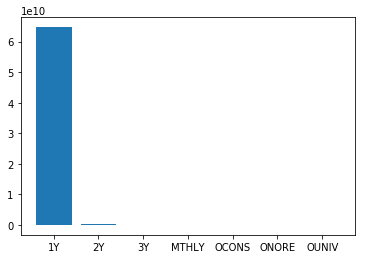

In [39]:
plt.bar(gb_a_config['Product Configtype ID'], gb_a_config['Completed Sales Doc Currency'])

### These type A amounts are very small!

In [ ]:
# OK now lets just filter this gb_a to only be 1Y, 2Y, 3Y and MTHLY

In [40]:
config_list = ['1Y', '2Y', '3Y', 'MTHLY']
test1 = gb_a['Product Configtype ID'].isin(config_list)
sum(test1)

3382

In [42]:
test1 = gb_a[gb_a['Product Configtype ID'].isin(config_list)]

## For now, lets just split this into gb_a_1Y, gb_a_2Y, gb_a_3y, gb_a_1M


In [43]:
gb_a_1Y = test1[test1['Product Configtype ID']=='1Y']
gb_a_2Y = test1[test1['Product Configtype ID']=='2Y']
gb_a_3Y = test1[test1['Product Configtype ID']=='3Y']
gb_a_1M = test1[test1['Product Configtype ID']=='MTHLY']

In [46]:
print('this is the lenght of type A 1M billings: ', len(gb_a_1M))
print('this is the lenght of type A 1Y billings: ', len(gb_a_1Y))
print('this is the lenght of type A 2Y billings: ', len(gb_a_2Y))
print('this is the lenght of type A 3Y billings: ', len(gb_a_3Y))

this is the lenght of type A 1M billings:  823
this is the lenght of type A 1Y billings:  1856
this is the lenght of type A 2Y billings:  657
this is the lenght of type A 3Y billings:  46


# TYPE D billings
These billings have a field 'Rule For Bill Date' that determines when new billings will occur
 - Monthly [Y1, Y2, Y3, Y5]
 - Quarterly [YQ]
 - Every 4 months [YT]
 - Semi-annual [YH]
 - Annual [YA, YC]
 - Every 2 years - [Y4]
 
 We also need to track the type D billings that do not have a 'Rule for Bill Date'

In [48]:
# for now just do a groupby on the type
# filtering just the type A billings
dfr_d = dfr[dfr['Revenue Recognition Category New']=='D']

In [49]:
gb_d = dfr_d.groupby(['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc',
                     'Rule For Bill Date'], as_index=False).sum()
gb_d.drop(labels='Subscription Term', axis=1, inplace = True)

In [50]:
gb_d_mthly = gb_d[gb_d['Rule For Bill Date'].isin(['Y1', 'Y2', 'Y3', 'Y5'])]
gb_d_qtrly = gb_d[gb_d['Rule For Bill Date']=='YQ']
gb_d_four_mths = gb_d[gb_d['Rule For Bill Date']=='YT']
gb_d_semi_ann = gb_d[gb_d['Rule For Bill Date']=='YH']
gb_d_annual = gb_d[gb_d['Rule For Bill Date'].isin(['YA', 'YC'])]
gb_d_two_yrs = gb_d[gb_d['Rule For Bill Date']=='Y4']

In [51]:
gb_d['Rule For Bill Date'].value_counts()

YA    1630
Y3    1438
YQ     530
Y1     256
YC     246
YH     243
Y2      95
Y4      23
Y7      18
YT       8
BT       1
Name: Rule For Bill Date, dtype: int64

### Note: There is one type D billings that is listed as 'BT' I don't know what this means, but it was a $180 EUR payment from January 2017, so we will ignore

In [52]:
print('Length of monthly', len(gb_d_mthly))
print('Length of quarterly', len(gb_d_qtrly))
print('Length of four months', len(gb_d_four_mths))
print('Length of semi ann', len(gb_d_semi_ann))
print('Length of annual', len(gb_d_annual))
print('Length of two years', len(gb_d_two_yrs))

Length of monthly 1789
Length of quarterly 530
Length of four months 8
Length of semi ann 243
Length of annual 1876
Length of two years 23


In [53]:
what_is_BT = gb_d[gb_d['Rule For Bill Date']=='YT']
what_is_BT.head(10)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Rule For Bill Date,Completed Sales Doc Currency
4054,USD,Experience Cloud,2015-06,YT,11666.60
4068,USD,Experience Cloud,2015-08,YT,549861.11
4081,USD,Experience Cloud,2015-10,YT,11666.60
4101,USD,Experience Cloud,2016-01,YT,612916.60
4106,USD,Experience Cloud,2016-02,YT,-601250.00
4166,USD,Experience Cloud,2016-12,YT,13440.00
4190,USD,Experience Cloud,2017-04,YT,13440.00
4214,USD,Experience Cloud,2017-08,YT,13440.00


## Note: There are only 8 payments (back from 2017) that paid on a 4 month basis. 
We will ignore these as well.

## NOW WE NEED TO BUILD A DATAFRAME THAT INTEGRATES THIS DATA

- We will have the following descriptive fields
   - Invoicing Fiscal Year-Period
   - Document Currency
   - Enterprise BU

- We will have the following fields based on rebilling rule
   - Recognized
   - Service
   - Monthly
   - Quarterly
   - Annual
   - Two Years
   - Three Years

In [54]:
# starting with service and revenue
df_merge1 = pd.merge(gb_rec, gb_svc, how='outer', 
                     left_on=['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'],
                    right_on=['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'])

In [55]:
df_merge1.sample(5)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,Completed Sales Doc Currency_x,Completed Sales Doc Currency_y
1251,GBP,Print & Publishing,2015-12,109931.88,NaN
1816,SEK,Creative,2018-02,366344.00,NaN
2007,SEK,Print & Publishing,2017-05,9300.00,NaN
842,EUR,Experience Cloud,2015-08,1165954.20,1846289.96
703,DKK,Other Solutions,2017-08,-55.00,NaN


In [56]:
gb_rec.columns

Index(['Document Currency', 'Enterprise Bu',
       'Invoicing Fiscal Year-Period Desc', 'Completed Sales Doc Currency'],
      dtype='object')

In [57]:
df_merge1.rename(index=str, columns={'Completed Sales Doc Currency_x':'recognized',
                                     'Completed Sales Doc Currency_y':'service'}, inplace=True)

In [58]:
df_merge2 = pd.merge(df_merge1, gb_b, how='outer', 
                     left_on=['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'],
                    right_on=['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'])

In [59]:
df_merge2.rename(index=str, columns={'Completed Sales Doc Currency':'deferred_B'}, inplace=True)

In [60]:
df_merge3 = pd.merge(df_merge2, gb_a_1M, how='outer', 
                     left_on=['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'],
                    right_on=['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'])

In [61]:
df_merge3.rename(index=str, columns={'Completed Sales Doc Currency': 'deferred_1M_a'}, inplace=True)

In [62]:
df_merge3.columns

Index(['Document Currency', 'Enterprise Bu',
       'Invoicing Fiscal Year-Period Desc', 'recognized', 'service',
       'deferred_B', 'Product Configtype ID', 'deferred_1M_a'],
      dtype='object')

In [65]:
df_merge3.drop(columns=['Product Configtype ID'], inplace=True)

In [66]:
df_merge3.head()

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,recognized,service,deferred_B,deferred_1M_a
0,AUD,Creative,2015-06,490156.86,NaN,NaN,-2758.57
1,AUD,Creative,2015-07,235045.62,NaN,NaN,-3380.48
2,AUD,Creative,2015-08,284334.70,NaN,NaN,-2883.40
3,AUD,Creative,2015-09,369648.88,NaN,NaN,-4480.56
4,AUD,Creative,2015-10,287292.48,NaN,NaN,-3188.41


In [105]:
def merge_new_dataframe(old_df, new_df, new_column):
    df_merged = pd.merge(old_df, new_df, how='outer', 
                     left_on=['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'],
                    right_on=['Document Currency', 'Enterprise Bu', 'Invoicing Fiscal Year-Period Desc'])
    df_merged.rename(index=str, columns={'Completed Sales Doc Currency': new_column}, inplace=True)
    
    #need to drop the product configtype id for merges where the new_df is of type A
    config_str = 'Product Configtype ID'
    rule_str = 'Rule For Bill Date'
    if config_str in df_merged.columns:
        df_merged.drop(columns=['Product Configtype ID'], inplace=True)
    
    if rule_str in df_merged.columns:
        df_merged.drop(columns=['Rule For Bill Date'], inplace=True)
        
    return df_merged

In [74]:
new_column = 'deferred_1Y_a'
df_merge4 = merge_new_dataframe(df_merge3, gb_a_1Y, new_column)

In [75]:
df_merge4.columns

Index(['Document Currency', 'Enterprise Bu',
       'Invoicing Fiscal Year-Period Desc', 'recognized', 'service',
       'deferred_B', 'deferred_1M_a', 'deferred_1Y_a'],
      dtype='object')

In [79]:
new_column = 'deferred_2Y_a'
df_merge4 = merge_new_dataframe(df_merge4, gb_a_2Y, new_column)

In [80]:
df_merge4.sample(5)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,recognized,service,deferred_B,deferred_1M_a,deferred_1Y_a,deferred_2Y_a
2169,USD,LiveCycle,2015-12,988034.05,NaN,NaN,NaN,2069136.37,NaN
796,EUR,Document Cloud,2015-08,2865799.94,NaN,NaN,-380.12,1289201.53,39150.0
402,CHF,Document Cloud,2018-07,1507.00,NaN,NaN,-80.98,16.38,NaN
1578,NOK,Creative,2016-11,219269.00,NaN,NaN,-7000.45,-174961.08,NaN
478,CHF,LiveCycle,2017-04,1300.00,NaN,NaN,NaN,NaN,NaN


In [97]:
# We need to do it this way when we get to a .py file!
list_df = [gb_rec, gb_svc, gb_b,
        gb_a_1M,    gb_a_1Y,    gb_a_2Y,       gb_a_3Y, 
        gb_d_mthly, gb_d_qtrly, gb_d_semi_ann, gb_d_annual, gb_d_two_yrs]

list_columns = ['recognized', 'service', 'deferred_B', 
    'deferred_1M_a', 'deferred_1Y_a', 'deferred_2Y_a', 'deferred_3Y_a',
    'deferred_1M_d', 'deferred_3M_d', 'deferred_6M_d', 'deferred_1Y_d', 'deferred_2Y_d']


In [108]:
def merge_all_dataframes(list_df, list_columns):
    for i, df in enumerate(list_df):
        print('This is i:', i)
        #print("This is the df: ", df.head())
        print('referencing the column: ', list_columns[i])

        if i==0:
            df_merged = list_df[0]
            df_merged.rename(index=str, columns={'Completed Sales Doc Currency': list_columns[i]}, inplace=True)
        else:
            df_merged = merge_new_dataframe(df_merged, df, list_columns[i])

    return df_merged
    

In [109]:
df = merge_all_dataframes(list_df, list_columns)

This is i: 0
referencing the column:  recognized
This is i: 1
referencing the column:  service
This is i: 2
referencing the column:  deferred_B
This is i: 3
referencing the column:  deferred_1M_a
This is i: 4
referencing the column:  deferred_1Y_a
This is i: 5
referencing the column:  deferred_2Y_a
This is i: 6
referencing the column:  deferred_3Y_a
This is i: 7
referencing the column:  deferred_1M_d
This is i: 8
referencing the column:  deferred_3M_d
This is i: 9
referencing the column:  deferred_6M_d
This is i: 10
referencing the column:  deferred_1Y_d
This is i: 11
referencing the column:  deferred_2Y_d


In [110]:
df.sample(10)

,Document Currency,Enterprise Bu,Invoicing Fiscal Year-Period Desc,recognized,service,deferred_B,deferred_1M_a,deferred_1Y_a,deferred_2Y_a,deferred_3Y_a,deferred_1M_d,deferred_3M_d,deferred_6M_d,deferred_1Y_d,deferred_2Y_d
1693,JPY,Experience Cloud,2017-07,45438289.98,35018750.00,40821000.00,NaN,943798.00,NaN,NaN,NaN,15375000.00,NaN,24350315.00,NaN
876,EUR,Document Cloud,2018-03,3194016.72,NaN,750.00,-2421.16,3501092.97,59770.00,NaN,441677.45,181213.13,NaN,2415274.87,NaN
485,CHF,Experience Cloud,2018-11,9546.89,79148.65,47876.55,NaN,154201.56,NaN,NaN,NaN,NaN,NaN,444700.00,NaN
3028,HKD,Document Cloud,2018-04,NaN,NaN,NaN,NaN,-1176.00,NaN,NaN,1907.00,NaN,NaN,22088.33,NaN
292,CAD,Experience Cloud,2015-12,174714.39,494318.35,185596.00,NaN,119799.54,NaN,NaN,7500.00,187314.59,NaN,247535.92,NaN
877,EUR,Document Cloud,2018-04,2726812.12,NaN,NaN,-1636.93,2144397.21,138492.00,NaN,334899.64,NaN,NaN,2594944.86,NaN
2353,USD,Creative,2016-04,4028866.42,725.00,NaN,367950.20,37803878.27,62595.56,NaN,62522523.59,421272.92,409825.0,16339776.66,NaN
1302,GBP,Experience Cloud,2016-08,1571505.55,886677.19,35394.00,NaN,585023.64,NaN,NaN,-8375.00,307345.80,NaN,533050.42,NaN
152,AUD,Experience Cloud,2018-06,1623337.26,1213382.60,2090691.90,NaN,1302298.86,NaN,NaN,14775.00,1074029.24,NaN,1229622.25,NaN
269,AUD,Print & Publishing,2018-11,49296.00,NaN,NaN,NaN,60094.67,4157.00,NaN,33511.53,NaN,NaN,54702.05,NaN


In [98]:
whos

Variable              Type         Data/Info
--------------------------------------------
a                     Index        Index(['USD', 'EUR', 'GBP<...>],\n      dtype='object')
config_list           list         n=4
config_str            str          Product Configtype ID
df                    str          gb_a_1Y
df_merge1             DataFrame         Document Currency   <...>\n[2302 rows x 5 columns]
df_merge2             DataFrame         Document Currency   <...>\n[2303 rows x 6 columns]
df_merge3             DataFrame         Document Currency   <...>\n[2335 rows x 7 columns]
df_merge4             DataFrame         Document Currency   <...>n[2476 rows x 12 columns]
dfr                   DataFrame          Document Currency  <...>[22919 rows x 10 columns]
dfr_a                 DataFrame          Document Currency  <...>n[7856 rows x 10 columns]
dfr_b                 DataFrame          Document Currency  <...>\n[997 rows x 10 columns]
dfr_d                 DataFrame          Do